# Dungeons & Data

This notebook focuses on accessing the [Dungeons & Dragons (Fifth Edition) API](https://www.dnd5eapi.co/) and exploring two questions about the monsters.

1. Are there any significant gaps in the monster coverage? Out of all the monsters available, are there niches in types, alignments, etc., that seem under-utilised?

2. Is there are clear relationship between monster stats and challenge rating? All monsters are assigned a challenge rating - essentially a difficulty level; it would be interesting to know to what extent the raw statistics of a monster link to its challenge level.

### Required libraries

In [52]:
import pandas as pd  # Manipulating data
import requests  # Accessing APIs
import seaborn as sns  # Visualisation
import matplotlib.pyplot as plt  # Visualisation
from textwrap import wrap  # Text formatting
from pandas.core.common import flatten  # Flatten lists of lists
from collections import Counter  # Count values

### Set-up

In [2]:
# Standardise visualisations

sns.set()

## Data sourcing

In [3]:
# Get the full list of monsters from the api
monster_list = requests.get("http://dnd5eapi.co/api/monsters").json()
print(f"Found {monster_list['count']} monsters.")

Found 322 monsters.


In [4]:
# Holder for monster details
monster_details = []

# For each monster in the list,
for monster in monster_list["results"]:
    # Get the monster details
    url = f"http://www.dnd5eapi.co/api/monsters/{monster['index']}"
    details = requests.get(url).json()
    # And add them to the holder
    monster_details.append(details)

In [5]:
# Convert the list of results into a dataframe

monsters = pd.DataFrame(monster_details)

In [6]:
# View a random sample

monsters.sample(3)

,_id,index,name,size,type,subtype,alignment,armor_class,hit_points,hit_dice,...,condition_immunities,senses,languages,challenge_rating,special_abilities,actions,legendary_actions,url,reactions,other_speeds
209,5eb89d690b1bb138c56764fa,ogre,Ogre,Large,giant,None,chaotic evil,11,59,7d10,...,[],"{'darkvision': '60 ft.', 'passive_perception': 8}","Common, Giant",2.0,NaN,"[{'name': 'Greatclub', 'desc': 'Melee Weapon A...",NaN,/api/monsters/ogre,NaN,NaN
307,5eb89d690b1bb138c5676561,worg,Worg,Large,monstrosity,None,neutral evil,13,26,4d10,...,[],"{'darkvision': '60 ft.', 'passive_perception':...","Goblin, Worg",0.5,"[{'name': 'Keen Hearing and Smell', 'desc': 'T...","[{'name': 'Bite', 'desc': 'Melee Weapon Attack...",NaN,/api/monsters/worg,NaN,NaN
46,5eb89d690b1bb138c5676455,black-pudding,Black Pudding,Large,ooze,None,unaligned,7,85,10d10,...,"[{'name': 'Blinded', 'url': '/api/conditions/b...",{'blindsight': '60 ft. (blind beyond this radi...,,4.0,"[{'name': 'Amorphous', 'desc': 'The pudding ca...","[{'name': 'Pseudopod', 'desc': 'Melee Weapon A...",NaN,/api/monsters/black-pudding,"[{'name': 'Split', 'desc': 'When a pudding tha...",NaN


In [7]:
# Check the dataframe size

monsters.shape

(322, 31)

In [8]:
monsters.columns

Index(['_id', 'index', 'name', 'size', 'type', 'subtype', 'alignment',
       'armor_class', 'hit_points', 'hit_dice', 'speed', 'strength',
       'dexterity', 'constitution', 'intelligence', 'wisdom', 'charisma',
       'proficiencies', 'damage_vulnerabilities', 'damage_resistances',
       'damage_immunities', 'condition_immunities', 'senses', 'languages',
       'challenge_rating', 'special_abilities', 'actions', 'legendary_actions',
       'url', 'reactions', 'other_speeds'],
      dtype='object')

## Data cleaning

In [9]:
# Drop columns that are API-,  rather than monster-related.

monsters.drop(["_id", "index", "url"], axis=1, inplace=True)

In [10]:
# Drop columns that are not required for this analysis

monsters = monsters[["name", "size", "type", "alignment", "armor_class",
                     "hit_points", "speed", "strength", "dexterity",
                     "constitution", "intelligence", "wisdom", "charisma",
                     "senses", "challenge_rating"]]

In [11]:
# Check for missing values in the overview

monsters.isna().sum()

name                0
size                0
type                0
alignment           0
armor_class         0
hit_points          0
speed               0
strength            0
dexterity           0
constitution        0
intelligence        0
wisdom              0
charisma            0
senses              0
challenge_rating    0
dtype: int64

## Data exploration

Text(0.5, 1.0, 'Monster counts by type')

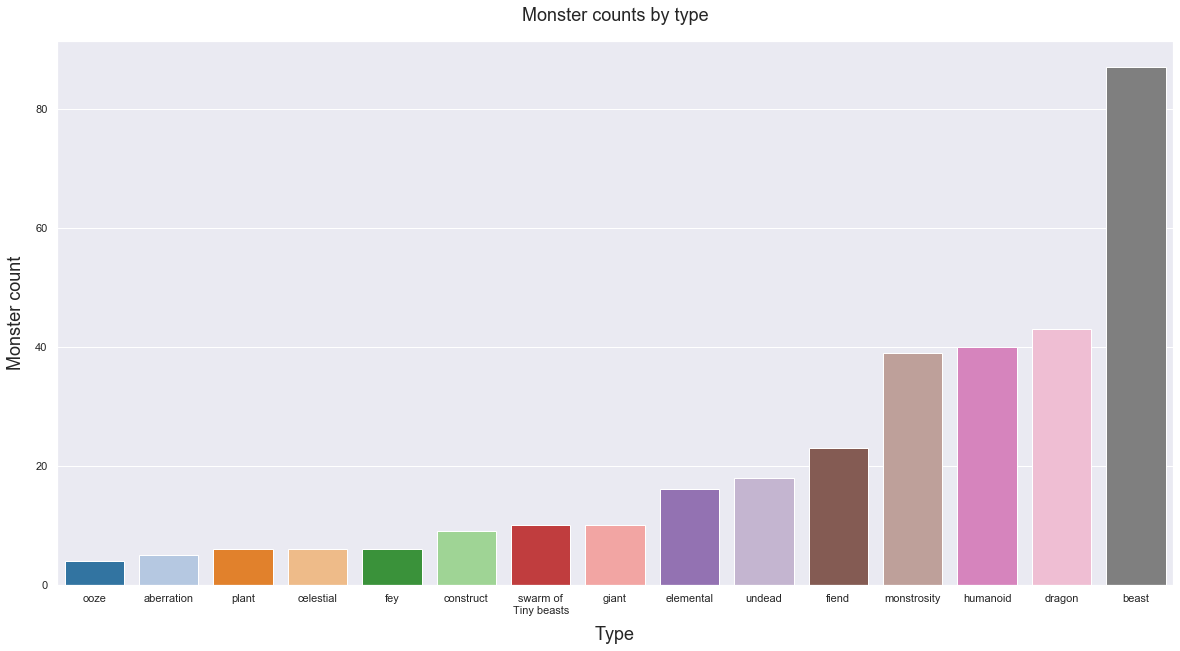

In [12]:
# Create a copy of the data for processing
vis_df = monsters.copy()
vis_df["type"] = vis_df["type"].apply(lambda x: "\n".join(wrap(x, 12)))

# Set the category names

plt.figure(figsize=(20,10))
plot = sns.countplot(vis_df["type"],
                     order= reversed(vis_df["type"].value_counts().index),
                     palette="tab20")
plot.set_ylabel("Monster count", fontsize=18, labelpad=10)
plot.set_xlabel("Type", fontsize=18, labelpad=10)
plot.set_title("Monster counts by type", fontsize=18, pad=20)

By far the most common type of monster is just "beast". Dragons are next, but this is because there are so many slightly-different types of dragon.

Celestial monsters seem comparatively rare compared to their fiendish counterparts.

Text(0.5, 1.0, 'Monster counts by size category')

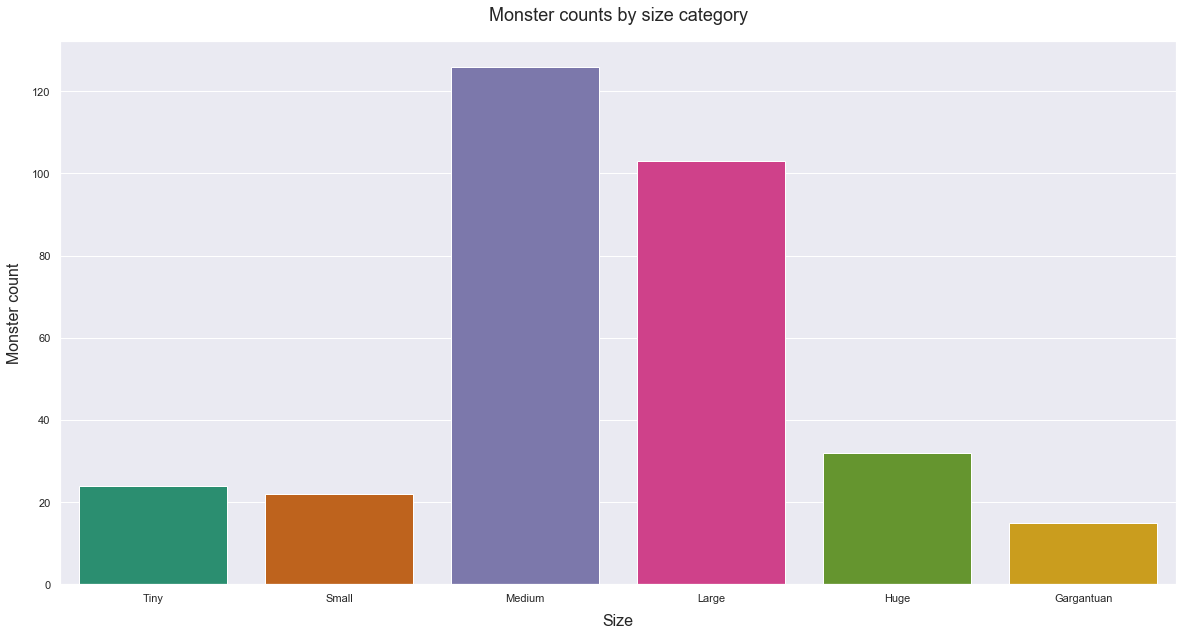

In [13]:
plt.figure(figsize=(20,10))
plot = sns.countplot(monsters["size"],
                     order=["Tiny", "Small", "Medium", "Large", "Huge", "Gargantuan"],
                     palette="Dark2")
plot.set_ylabel("Monster count", fontsize=16, labelpad=10)
plot.set_xlabel("Size", fontsize=16, labelpad=10)
plot.set_title("Monster counts by size category", fontsize=18, pad=20)

Text(0.5, 1, 'Monster numbers by alignment counts')

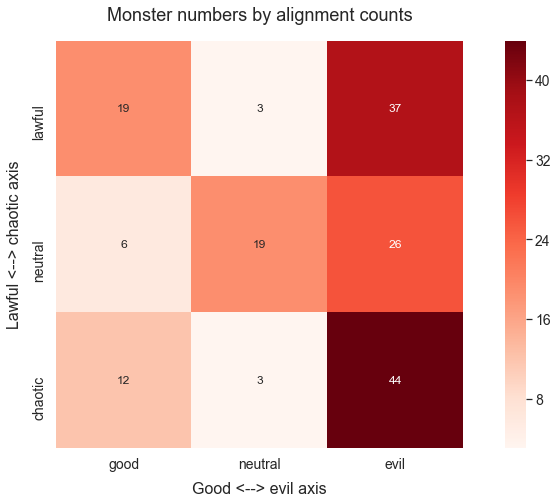

In [14]:
# Create a copy of the data for processing
vis_df = monsters.copy()

# Remove monsters with complicated alignments
vis_df = vis_df[~vis_df["alignment"].isin(["neutral good (50%) or neutral evil (50%)",
                                           "any non-lawful alignment",
                                           "any chaotic alignment",
                                           "any evil alignment",
                                           "any non-good alignment",
                                           "any alignment",
                                           "unaligned"])] 

# Create a morality column
vis_df["morality"] = vis_df["alignment"].apply(lambda x: "unaligned" if x == "unaligned"
                                               else "good" if "good" in x
                                               else "evil" if "evil" in x
                                               else "neutral")

# Create an outlook column
vis_df["outlook"] = vis_df["alignment"].apply(lambda x: "unaligned" if x == "unaligned"
                                              else "lawful" if "lawful" in x
                                              else "chaotic" if "chaotic" in x
                                              else "neutral")

# Create cross table and reorder it
vis_df = pd.crosstab(vis_df["morality"], vis_df["outlook"])
vis_df = vis_df[["lawful", "neutral", "chaotic"]].T[["good", "neutral", "evil"]]

# Visualise alignment combinations
plt.figure(figsize=(15, 7.5))
sns.set_context(rc={"xtick.labelsize":14,
                    "ytick.labelsize":14})
plot = sns.heatmap(vis_df, cmap="Reds", annot=True, square=True)
plot.set_ylabel("Lawful <--> chaotic axis", fontsize=16, labelpad=10)
plot.set_xlabel("Good <--> evil axis", fontsize=16, labelpad=10)
plot.set_title("Monster numbers by alignment counts", fontsize=18, pad=20)

As might reasonably be expected, evil monsters are the most common type. The most neglected niches though, aren't the good slots - neutral monsters are the least likely overall.

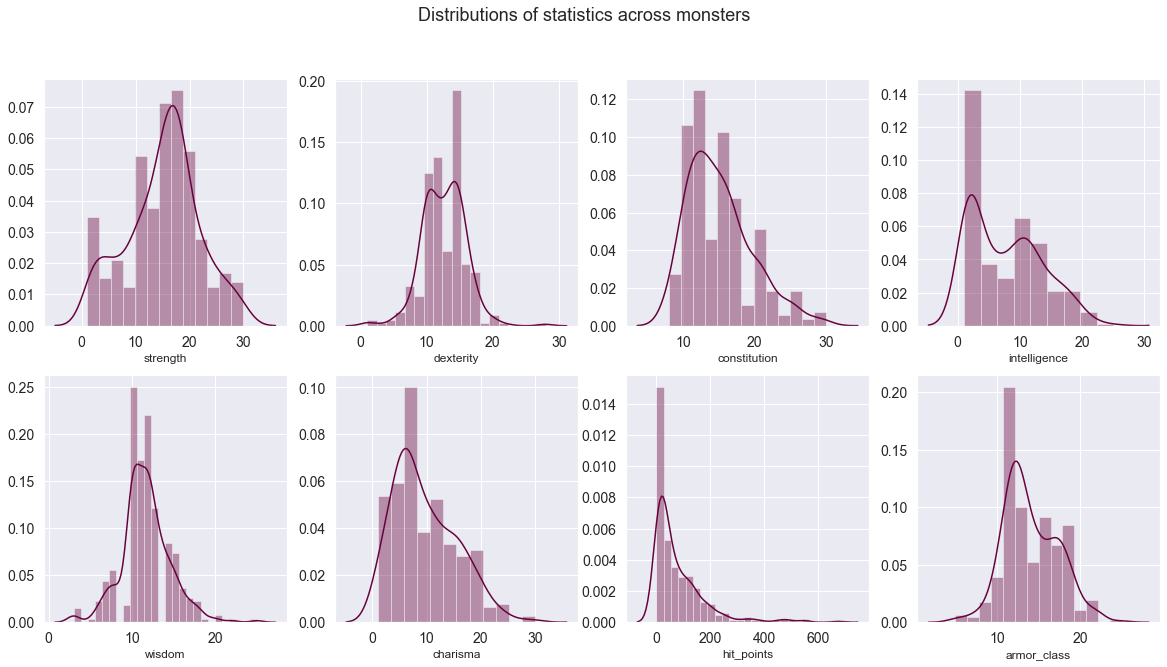

In [15]:
fig, plots = plt.subplots(2, 4, figsize=(20,10))
fig.suptitle("Distributions of statistics across monsters", fontsize=18)
plots = list(flatten(plots))
stats = ["strength", "dexterity", "constitution", "intelligence", "wisdom", "charisma", "hit_points", "armor_class"]
for i in range(8):
    sns.distplot(monsters[stats[i]], ax=plots[i], color="#66023C")


The distributions suggest a couple of interesting things. Higher strengths seem to be more common with monsters than high intelligence or wisdom - a neglected type of monster might be the cerebral, rather than physical sort.

Hit points have the widest distribution by far, and operate on a completely different scale to the other stats.

## Senses and movement

Text(0.5, 1.0, 'Sense type by monster count')

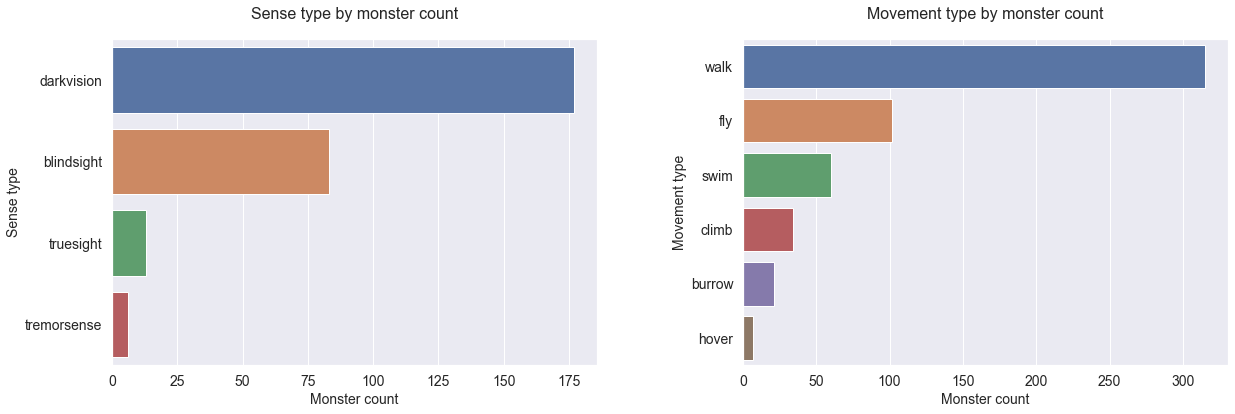

In [16]:
# Set up side-by-side plots

fig, plots = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(wspace=0.3)

# Count the monsters for each different kind of movement

movement = list(flatten(monsters["speed"].apply(lambda x: x.keys()).to_list()))

move_counts = Counter(movement)

move_counts = pd.Series(move_counts).sort_values(ascending=False)

# Plot the monster counts
plot = sns.barplot(x=move_counts, y=move_counts.index, ax=plots[1])
plot.set_ylabel("Movement type", fontsize=14)
plot.set_xlabel("Monster count", fontsize=14)
plot.set_title("Movement type by monster count", fontsize=16, pad=20)

# Count the monsters for each different kind of sense

senses = list(flatten(monsters["senses"].apply(lambda x: x.keys()).to_list()))

sense_counts = Counter(senses)

sense_counts = pd.Series(sense_counts).sort_values(ascending=False)

# Remove passive perception
del sense_counts["passive_perception"]

# Plot the monster counts
plot = sns.barplot(x=sense_counts, y=sense_counts.index, ax=plots[0])
plot.set_ylabel("Sense type", fontsize=14)
plot.set_xlabel("Monster count", fontsize=14)
plot.set_title("Sense type by monster count", fontsize=16, pad=20)

Burrowing and tremor sense are both rare amongst monsters. This clearly sugests an unfilled niche, as these two attributes are related, and would make sense together.

## Investigating stats and challenge rating

In [29]:
# Create a dataframe of just numeric columns

num_df = monsters[["strength", "dexterity", "constitution", "intelligence",
                   "wisdom", "charisma", "hit_points", "armor_class", "challenge_rating"]].copy()

In [30]:
# Check types

num_df.dtypes

strength              int64
dexterity             int64
constitution          int64
intelligence          int64
wisdom                int64
charisma              int64
hit_points            int64
armor_class           int64
challenge_rating    float64
dtype: object

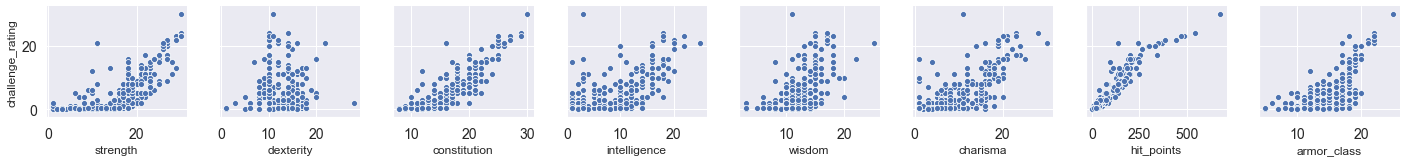

In [51]:
# Look for interesting correlations with challenge_rating
sns.pairplot(x_vars=num_df.drop("challenge_rating", axis=1).columns,
             y_vars="challenge_rating",
             data=num_df)

In [39]:
# Check numeric correlations

cluster_df.corr().loc["challenge_rating"].round(2)

strength            0.72
dexterity          -0.02
constitution        0.86
intelligence        0.64
wisdom              0.55
charisma            0.69
hit_points          0.94
armor_class         0.76
challenge_rating    1.00
Name: challenge_rating, dtype: float64

Text(0.5, 0, 'Hit points')

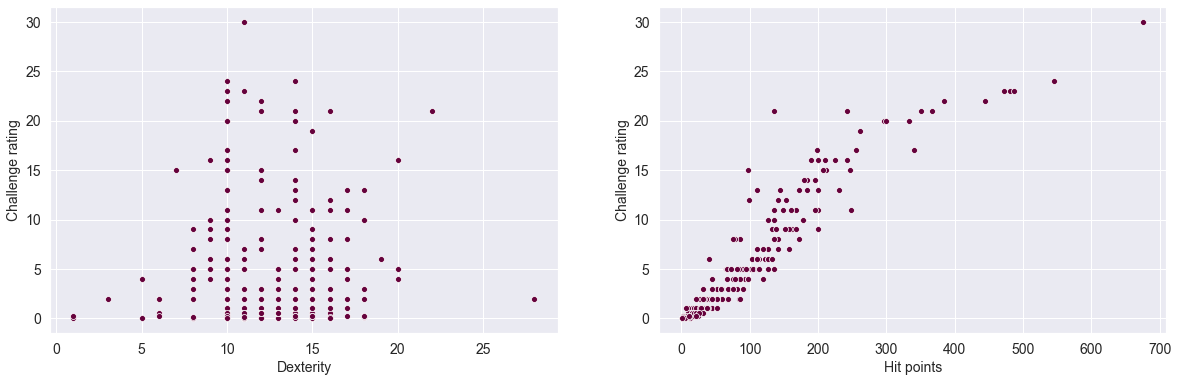

In [44]:
# Make the most interesting two plots larger

# Set up side-by-side plots

fig, plots = plt.subplots(1, 2, figsize=(20, 6))

# Build the scatterplots

plot = sns.scatterplot(y="challenge_rating", x="dexterity", data=num_df, ax=plots[0], color="#66023C")
plot.set_ylabel("Challenge rating", fontsize=14)
plot.set_xlabel("Dexterity", fontsize=14)

plot = sns.scatterplot(y="challenge_rating", x="hit_points", data=num_df, ax=plots[1], color="#66023C")
plot.set_ylabel("Challenge rating", fontsize=14)
plot.set_xlabel("Hit points", fontsize=14)

In general, the different stats show a positive correlation with challenge rating: as the stats go up, the monster gets harder to defeat. This is particularly noticeable for hit points, which is the most strongly correlated by far. 

This is not a surprising conclusion, though it is a little disappointing - I had hoped that stats wouldn't be quite as clearly linked, and that a lot of the difficulty would come through exciting spells and abilities. Apparently though, one of the primary ways to make a monster more challenging is just to bump up the numbers.

Dexterity is the only exception - the one stat that doesn't show a significant correlation. Unlike the other plots, which form the expected roughly-diagonal line, dexterity is all over the place. This suggests that dexterity has less of an impact on CR than the other stats do.